In [102]:
import cv2
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm
import tensorflow as tf

print(tf.__version__)
#print (cv2.__version__)
TRAIN_DIR = '../dogs-vs-cats/train/train'
TEST_DIR = '../dogs-vs-cats/test1/test1'
IMG_SIZE = 50
# what does this mean? 
LR = 1e-3 

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '8conv-basic')

2.8.0


In [103]:
def label_img(img):
    # dog.93.png 
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog' : return [0, 1]

In [104]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)        
    np.save('train_data.npy', training_data)
    return training_data 


In [105]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data 


In [106]:
if not os.path.exists('train_data.npy'):
    train_data = create_train_data()
    print('create_train_data')
else:
    # if already have train data:
    train_data = np.load("train_data.npy", allow_pickle=True)
    print('train_data.npy loaded')


train_data.npy loaded


In [107]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
#import tflearn.datasets.mnist as mnist

import tensorflow as tf
tf.compat.v1.reset_default_graph()
# X, Y, test_x, test_y = mnist.load_data(one_hot=True)

# X = X.reshape([-1, 28, 28, 1])
# test_x = test_x.reshape([-1, 28, 28, 1])

# update size 
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

# update layers
convnet = fully_connected(convnet, 2, activation='softmax')
# update learning rate 
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

# add log 
model = tflearn.DNN(convnet, tensorboard_dir='log')
# model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
#     snapshot_step=500, show_metric=True, run_id='mnist')

In [108]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')


INFO:tensorflow:Restoring parameters from c:\Dev\Python\jupyter\UseCNNtoIdentifyDogsVsCats\script2\dogsvscats-0.001-8conv-basic.model
model loaded!


In [109]:
train = train_data[:-500]
test = train_data[-500:]

In [122]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]
print(X[0].shape)
print(X.shape)
print(np.array(Y).shape)

X2 = np.array([i[0].reshape(IMG_SIZE, IMG_SIZE, 1) for i in train])
print(X2[0].shape)
print(X2.shape)

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]
print(test_x.shape)
print(test_x[0].shape)


(50, 50, 1)
(24500, 50, 50, 1)
(24500, 2)
(50, 50, 1)
(24500, 50, 50, 1)
(500, 50, 50, 1)
(50, 50, 1)


In [61]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

#tensorboard --logdir=foo:C:\Dev\Python\jupyter\UseCNNtoIdentifyDogsVsCats\log

Training Step: 1914  | total loss: 0.41682 | time: 3.185s
| Adam | epoch: 005 | loss: 0.41682 - acc: 0.8163 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.42759 | time: 4.210s
| Adam | epoch: 005 | loss: 0.42759 - acc: 0.8034 | val_loss: 0.53197 - val_acc: 0.7280 -- iter: 24500/24500
--


In [62]:
model.save(MODEL_NAME)

INFO:tensorflow:c:\Dev\Python\jupyter\UseCNNtoIdentifyDogsVsCats\script2\dogsvscats-0.001-8conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [63]:
import matplotlib.pyplot as plt

if not os.path.exists('test_data.npy'):
    test_data = process_test_data()
    print('process_test_data')
else:
    # if already have train data:
    test_data = np.load("test_data.npy", allow_pickle=True)
    print('test_data.npy loaded')

test_data.npy loaded


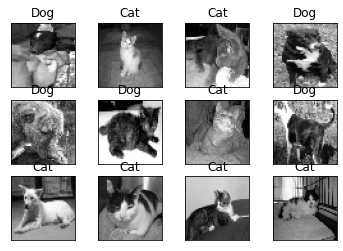

In [129]:
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat: [1, 0]
    #dog: [0, 1]
    img_num = data[1]
    img_data = data[0]

    y = fig.add_subplot(3, 4, num+1)

    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

    predict_out = model.predict([data])[0]

    # print(model.predict([data]))
    if np.argmax(predict_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'

    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()



In [130]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [ ]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data 
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))
        #cat: [1, 0]
        #dog: [0, 1] thus return dogness 
